In [ ]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#  Copyright (c) 2021. Reda Bouadjenek, Deakin University                      +
#     Email:  reda.bouadjenek@deakin.edu.au                                    +
#                                                                              +
#  Licensed under the Apache License, Version 2.0 (the "License");             +
#   you may not use this file except in compliance with the License.           +
#    You may obtain a copy of the License at:                                  +
#                                                                              +
#                 http://www.apache.org/licenses/LICENSE-2.0                   +
#                                                                              +
#    Unless required by applicable law or agreed to in writing, software       +
#    distributed under the License is distributed on an "AS IS" BASIS,         +
#    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  +
#    See the License for the specific language governing permissions and       +
#    limitations under the License.                                            +
#                                                                              +
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


**Author:** [Mohamed Reda Bouadjenek](https://rbouadjenek.github.io/), Lecturer of Applied Artificial Intelligence, 

**Institution:** Deakin University, School of Information Technology, Faculty of Sci Eng & Built Env

**Adress:** Locked Bag 20000, Geelong, VIC 3220

**Phone:** +61 3 522 78380

**Email:** reda.bouadjenek@deakin.edu.au

<img style="float: left;" src="images/deakin2.png" width="200">

# Introduction

**Welcome to the Notebook for the Deakin Simpsons Challenge 2021!**

![](images/Simpsons_cast2.png)



This Notebook allows you to build a classification model for The Deakin Simpsons challenge 2021.

The **Deakin Simpsons challenge 2021** is a computer vision competition for which the goal is to recognize Simpsons characters individually in images using machine learning/deep learning. The challenge is designed to provide students with the opportunity to work as team members, to compete with each other, and to enhance the student learning experience by improving their AI modeling, problem-solving, and team-working skills.
 


As participants, your goal is to build a machine learning/deep learning model to automatically recognize the following Simpsons characters:

 
1. [Abraham grampa simpson](https://en.wikipedia.org/wiki/Grampa_Simpson)
2. [Apu nahasapeemapetilon](https://en.wikipedia.org/wiki/Apu_Nahasapeemapetilon)
3. [Bart simpson](https://en.wikipedia.org/wiki/Bart_Simpson)
4. [Charles montgomery burns](https://en.wikipedia.org/wiki/Mr._Burns)
5. [chief wiggum](https://en.wikipedia.org/wiki/Chief_Wiggum)
6. [Comic book guy](https://en.wikipedia.org/wiki/Comic_Book_Guy)
7. [Edna krabappel](https://en.wikipedia.org/wiki/Edna_Krabappel)
8. [Homer simpson](https://en.wikipedia.org/wiki/Homer_Simpson)
9. [Kent brockman](https://en.wikipedia.org/wiki/Kent_Brockman)
10. [Krusty the clown](https://en.wikipedia.org/wiki/Krusty_the_Clown)
11. [Lenny leonard](https://simpsons.fandom.com/wiki/Lenny_Leonard)
12. [Lisa simpson](https://en.wikipedia.org/wiki/Lisa_Simpson)
13. [Marge simpson](https://en.wikipedia.org/wiki/Marge_Simpson)
14. [Mayor quimby](https://en.wikipedia.org/wiki/Mayor_Quimby)
15. [Milhouse van houten](https://en.wikipedia.org/wiki/Milhouse_Van_Houten)
16. [Moe szyslak](https://en.wikipedia.org/wiki/Moe_Szyslak)
17. [Ned flanders](https://en.wikipedia.org/wiki/Ned_Flanders)
18. [Nelson muntz](https://en.wikipedia.org/wiki/Nelson_Muntz)
19. [Principal skinner](https://en.wikipedia.org/wiki/Principal_Skinner)
20. [Sideshow bob](https://en.wikipedia.org/wiki/Sideshow_Bob)


To achieve this taks, you will be given a data set that consists of 19,548 images to train your model and to tune your hyperparameters. However, feel free to extend it by collecting new images or by using data augmentation techniques.

Once you have built your model, you will have to submit it on the [CodaLab](https://competitions.codalab.org/competitions/27191?secret_key=f0a7cc3e-7f78-4bb1-8564-95bc2fadafa5) platform to be evaluated. 
We evaluate the performance of your model using the [Accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)  on a private test set that we have directly collected and labeled from TV show episodes.
Once the evaluation completed, your entry will appear on the leaderboard to see your performance against other competitors.


In the following, we will take you through  a 6-step process to build a simple model to perform this task as follows:

1. `Setup the environment:` Thie first step consists of setting the environement and downloading the data.
2. `Preprocessing:` The second step is a preprocessing step that consists of resizing, plitting, and piping the input data.
3. `Exploring the data:` The third step consists of a simple data exploration step where you will see samples of the data and some statistics to help you in understanding the data.
4. `Designing the model:` The forth step consists of designing an architecture for the task.
5. `Traning:` The fifth step consists of starting the training process.
6. `Monitoring:` The sixth step consists of monitoring the traning process to investigate possible overfitting.
7. `Submission:` The seventh and last step will take you through the submission process.


**References:**

- [The Simpsons characters recognition and detection using Keras](https://medium.com/alex-attia-blog/the-simpsons-character-recognition-using-keras-d8e1796eae36)


# Setup the environment


First, it is important to mention that in order to submit you model to the leaderbord, you need to generate it and save it using  <span style="color:red;font-weight: bold;">TensorFlow 2.2.0</span> and not  <span style="color:red;font-weight: bold;text-decoration: line-through;">TensorFlow 2.3.0</span>. Therefore, please first run the following cell to install the appropriate <span style="color:red;font-weight: bold;">TensorFlow version (2.2.0)</span>. You may need to restart your kernel.

In [ ]:
# Run this to install the appropriate tensorflow package
!pip install tensorflow==2.2.0


Once the appropriate TensorFlow version installed, you need now to load all the required packages for this Notebook.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, classification_report
from tensorflow.keras import models, layers, optimizers
from tensorflow.python.keras.saving import hdf5_format
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
import h5py, itertools, collections
import itertools

##################
# Verifications:
#################
print('GPU is used.' if len(tf.config.list_physical_devices('GPU')) > 0 else 'GPU is NOT used.')
print("Tensorflow version: " + tf.__version__)

Now, please run the following cell to download the dataset that you will use to build your model.

In [ ]:
# Download dataset:
!wget http://206.12.93.90:8080/simpson_dataset/simpsons_train.tar.gz 
# Unzip the dataset:
!tar -xzvf simpsons_train.tar.gz > /dev/null

# Preprocessing


We use the Simpson character data available in [kaggle](https://www.kaggle.com/alexattia/the-simpsons-characters-dataset). 

This dataset is composed of 20 folders (one for each character) with 400-2000 images in each folder. The total number of images is 19,548.

For reading these images, we use `DirectoryIterator` in `tf.keras.preprocessing.image` that is an iterator capable of reading images from a directory on disk and is capable to extract labels. We also use `ImageDataGenerator` to split this dataset into training and validation set, this later is used to tune the hyperparameters of our model.


In [ ]:
'''
    Split train and validation.
'''
# We define the size of input images to 128x128 pixels.
image_size = (128, 128)
# We define the batch size
batch_size = 64

# Create an image generator with a fraction of images reserved for validation:
image_generator = ImageDataGenerator(validation_split=0.1)

# Now, we create a training data iterator by creating batchs of images of the same size as 
# defined previously, i.e., each image is resized in a 64x64 pixels format.
train_ds =  DirectoryIterator(
    "dataset/simpsons_train/",
    image_generator,
    class_mode='categorical',
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    subset = 'training',
)

# Similarly, we create a validation data iterator by creating batchs of images of the same size as 
# defined previously, i.e., each image is resized in a 64x64 pixels format.
val_ds = DirectoryIterator(
    "dataset/simpsons_train/",
    image_generator,
    class_mode='categorical',
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    subset = 'validation',
    shuffle=False
)

# We save the list of classes (labels).
class_names = list(train_ds.class_indices.keys())

# We also save the number of labels.
num_classes = train_ds.num_classes


# Exploring the data

Now, we do data exploration to show you samples of the images and their labels and some statistics to help you in understanding the data.

In [ ]:
###############################################
#### Show distribution of images per class.
###############################################
counter=collections.Counter(train_ds.labels)
v = [ [class_names[item[0]],item[1]]  for item in counter.items()]
df = pd.DataFrame(data=v, columns=['index','value'])
g = sns.catplot(x='index', y= 'value',  data=df, kind='bar', 
                legend=False,height=4,aspect=4,saturation=1)
(g.despine(top=False,right=False))
plt.xlabel("Classes")
plt.ylabel("#images")
plt.title("Distribution of images per class")
plt.xticks(rotation='vertical')
plt.show()

#####################################
######### Show sample of images.
#####################################
plt.figure(figsize=(16, 16))
images = []
labels = []
for itr in train_ds.next():
    for i in range(25):
        if len(images) < 25:
            images.append(itr[i].astype("uint8"))
        else:
            labels.append(list(itr[i]).index(1))

for i in range(len(images)):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i]].replace('_',' ') +' ('+str(int(labels[i]))+')')
    plt.axis("off")
    


# Designing the model


We now design the architecture for the task. The artchitecture below consists of:
1. `Rescaling layer:` whose role is to normalize the input data to values between 0 and 1. This will help in speed up the training process.
2. `CNN block 1:` which consists of a Convolution layer followed by a max pulling.
3. `CNN block 2:` which consists of a Convolution layer followed by a max pulling.
4. `CNN block 3:` which consists of a Convolution layer followed by a max pulling.
5. `CNN block 4:` which consists of a Convolution layer followed by a max pulling.
6. `Flatten layer:` whose role is just to flatten the volume.
7. `Dense layers`: one dense layer followed by a classification layer with a softmax activation function.

Please note that you will have to design your own model if you want to beat the baseline and be at the top of the leaderboard!

In [ ]:
# Defining the model here:
model = models.Sequential()
model.add(keras.Input(shape=image_size + (3,))) 
model.add(layers.experimental.preprocessing.Rescaling(1./255))
# CNN block 1
model.add(layers.Conv2D(4, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
# # CNN block 2     
model.add(layers.Conv2D(8, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
# # CNN block 3       
model.add(layers.Conv2D(16, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
# # CNN block 4       
model.add(layers.Conv2D(32, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
#Dense part
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

# Print a summary of the model
model.summary()

# Compiling the model by defininf an optimizer, a loss function, 
# and the metrics to be used for monitoring the traning.
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])


# Traning

Let's now starting the training process.

In [ ]:
# Start the trining by defining the number of epochs to train, the traing set and the validation set.
history = model.fit(
    train_ds, epochs=6, 
    validation_data=val_ds,
)


Save the created model. It is important to note that we are saving with the model:
1. The `class_names`: which is important for submission as we will submit class names and not indexes.
2. The `image_size`: which is important to resize the test images.

In [ ]:

with h5py.File('model.h5', mode='w') as f:
    hdf5_format.save_model_to_hdf5(model, f)
    f.attrs['class_names'] = class_names
    f.attrs['image_size'] = image_size

# Monitoring and analysis of the model

The next step consists of monitoring the traning process to investigate possible overfitting.


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,4))

ax1 = plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.fill_between(epochs, loss,val_loss,color='g',alpha=.1)

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

ax2 = plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.fill_between(epochs, acc,val_acc,color='g',alpha=.1)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Run the `classification_report` function below to build a text report showing the main classification metrics for your model:

In [ ]:
val_ds.reset()
val_ds.shuffle = False
val_ds.next()
y_prob = model.predict(val_ds)
y_pred = y_prob.argmax(axis=-1)
y_true = val_ds.labels
print(classification_report(y_true, y_pred, target_names=class_names))

Run the  next cell to create a confusion matrix function `plot_confusion_matrix`.

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    vmax = cm.max()
    if normalize:
        title = 'Confusion matrix (normalized)'
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = [[int(j*100) for j in i ] for i in cm]
        cm =np.array(cm)
        vmax = 100
        
    plt.figure(figsize=(8,8))

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=vmax)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar(im,fraction=0.046, pad=0.04)



Let's now create the confusion matrix.

In [ ]:
val_ds.reset()
val_ds.shuffle = False
val_ds.next()
y_prob = model.predict(val_ds)
y_pred = y_prob.argmax(axis=-1)
y_true = val_ds.labels
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm=cnf_matrix, classes=class_names, title='Confusion Matrix', normalize=True)


Have a look at the confusion matrix, and observe what classes are confused with each other.

Let's now have a look at example of predictions made by your model:

In [ ]:
val_ds.reset()
val_ds.shuffle = True
#####################################
######### Show sample of images.
#####################################
plt.figure(figsize=(16, 16))
images = []
labels_pred = []
labels_true = []
for itr in val_ds.next():
    for i in range(25):
        if len(images) < 25:
            images.append(itr[i].astype("uint8"))
            y_proba = model.predict(np.array([itr[i]]))
            y_pred = np.argmax(y_proba,axis=1)[0]
            labels_pred.append(y_pred)
        else:
            labels_true.append(list(itr[i]).index(1))
    

for i in range(len(images)):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])    
    title = 'Pred: ' + class_names[labels_pred[i]].replace('_',' ') +'\n' +'True: ' + class_names[labels_true[i]].replace('_',' ') 
    
    
    plt.title(title,fontsize= 11, pad=5)
    plt.axis("off")
#     plt.subplots_adjust(left=None, bottom=0.1, right=None, top=1, wspace=None, hspace=None)

    



Observe where are the errors!

# How to submit the model to CodaLab?

Congratulation, you have sucessfully created your model and you need now to submit it to CodaLab!

CodaLab is an open-source web-based platform that enables researchers, developers, and data scientists to organize and participate to data science ana machine learning competitions.

Submitting your model to CodaLab is very simple. You need to follow the following steps:

1. Mount your Google Drive by runing this code:


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

2. Copy the model to your Google Drive by runing the following code:

In [ ]:
!cp model.h5 'drive/My Drive/'

3. Now, go to your Google Drive and you will find a file called `model.h5`.



4. Copy the model file `model.h5` you have created to the directory `deakin_ai_challenge_submission`.



5. Zip `deakin_ai_challenge_submission/` to generate `deakin_ai_challenge_submission.zip`.


6. Submit `deakin_ai_challenge_submission.zip` to CodaLab  following these steps.


6. Your submission will appear here. Just wait until it is processed (it may take time)!


***Watch the video below:***



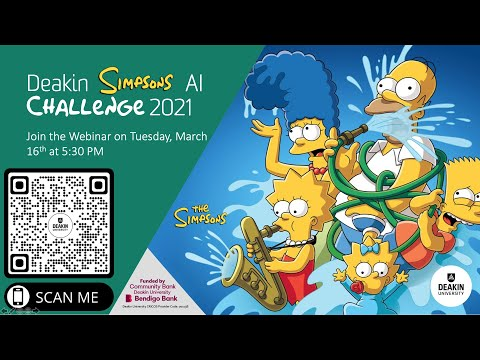

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('UVP4yATavFM',  width=1000, height=600)


**Congratulation on building your model and submitting to CodaLab! We hope that your model will achieve a high accuracy on the testset.**


# Acknowledgment


**Author:** [Mohamed Reda Bouadjenek](https://rbouadjenek.github.io/), Lecturer of Applied Artificial Intelligence, 

**Institution:** Deakin University, School of Information Technology, Faculty of Sci Eng & Built Env

**Adress:** Locked Bag 20000, Geelong, VIC 3220

**Phone:** +61 3 522 78380

**Email:** reda.bouadjenek@deakin.edu.au

**www.deakin.edu.au**

<div>
<img style="float: left;" src="images/deakin2.png" width="200" >
</div>
<br>
<br>
<br>
<br>

<div>  <a href="https://twitter.com/DeakinAI2021" > <img style="float: left;" src="https://irisconnect.com/uk/wp-content/uploads/sites/3/2020/12/twitter-Follow-us-button.png" width="200" > </a>
</div>